<a href="https://colab.research.google.com/github/joaobat/Classificao-R-git/blob/master/RNA_Matematica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Criando uma rede neural artificial usando apenas matematica

In [1]:
import numpy as np


In [2]:
# Função para inicialização randômica dos parâmetros do modelo
def inicializa_parametros(dims_camada_entrada):
    
    # Dicionário para os parâmetros
    parameters = {}
    
    # Comprimento das dimensões das camadas
    comp = len(dims_camada_entrada)
    
    # Loop pelo comprimento
    for i in range(1, comp):
        
        # Inicialização da matriz de pesos
        parameters["W" + str(i)] = np.random.randn(dims_camada_entrada[i], dims_camada_entrada[i - 1]) * 0.01
        
        # Inicialização do bias
        parameters["b" + str(i)] = np.zeros((dims_camada_entrada[i], 1))
    
    return parameters

In [3]:
# Função sigmóide
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [4]:
# Função de ativação ReLu (Rectified Linear Unit)
def relu(Z):
    A = abs(Z * (Z > 0))
    return A, Z

In [5]:
# Operação de ativação
# A é a matriz com os dados de entrada
# W é a matriz de pesos
# b é o bias
def linear_activation(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [6]:
# Movimento para frente (forward)
def forward(A_prev, W, b, activation):
    
    # Se a função de ativação for Sigmoid, entramos neste bloco
    if activation == "sigmoid":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    # Se não, se for ReLu, entramos neste bloco    
    elif activation == "relu":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [7]:
# Propagação para frente
def forward_propagation(X, parameters):
    
    # Lista de valores anteriores (cache)
    caches = []
    
    # Dados de entrada
    A = X
    
    # Comprimento dos parâmetros
    L = len(parameters) // 2
   
    # Loop
    for i in range(1, L):
      
        # Guarda o valor prévio de A
        A_prev = A
        
        # Executa o forward
        A, cache = forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], activation = "relu")
        
        # Grava o cache
        caches.append(cache)
    
    # Saída na última camada
    A_last, cache = forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    
    # Grava o cache
    caches.append(cache)
    
    return(A_last, caches)

In [8]:
# Função de custo (ou função de erro)
def calcula_custo(A_last, Y):
    
    # Ajusta o shape de Y para obter seu comprimento (total de elementos)
    m = Y.shape[1]
    
    # Calcula o custo comparando valor real e previso
    custo = (-1 / m) * np.sum((Y * np.log(A_last)) + ((1 - Y) * np.log(1 - A_last)))
    
    # Ajusta o shape do custo
    custo = np.squeeze(custo)
    
    return(custo)

In [9]:
# Função sigmoid para o backpropagation 
# Fazemos o cálculo da derivada pois não queremos o valor completo da função, mas sim sua variação
def sigmoid_backward(da, Z):
    
    # Calculamos a derivada de Z
    dg = (1 / (1 + np.exp(-Z))) * (1 - (1 / (1 + np.exp(-Z))))
    
    # Encontramos a mudança na derivada de z
    dz = da * dg
    return dz

# Compare com a função sigmoid do forward propagation
# A = 1 / (1 + np.exp(-Z))

In [10]:
# Função relu para o backpropagation 
# Fazemos o cálculo da derivada pois não queremos o valor completo da função, mas sim sua variação
def relu_backward(da, Z):
    
    dg = 1 * ( Z >= 0)
    dz = da * dg
    return dz

# Compare com a função relu do forward propagation:
# A = abs(Z * (Z > 0))

In [11]:
# Ativação linear para o backpropagation
def linear_backward_function(dz, cache):
    
    # Recebe os valores do cache (memória)
    A_prev, W, b = cache
    
    # Shape de m
    m = A_prev.shape[1]
    
    # Calcula a derivada de W (resultado da operação com dz)
    dW = (1 / m) * np.dot(dz, A_prev.T)
    
    # Calcula a derivada de b (resultado da operação com dz)
    db = (1 / m) * np.sum(dz, axis = 1, keepdims = True)
    
    # Calcula a derivada da operação
    dA_prev = np.dot(W.T, dz)
    
    return dA_prev, dW, db

In [12]:
# Função que define o tipo de ativação (relu ou sigmoid)
def linear_activation_backward(dA, cache, activation):
    
    # Extrai o cache
    linear_cache, activation_cache = cache
    
    # Verifica se a ativação é relu
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    # Verifica se a ativação é sigmoid
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    return dA_prev, dW, db

In [13]:
# Algoritmo Backpropagation (calcula os gradientes para atualização dos pesos)
# AL = Valor previsto no Forward
# Y = Valor real
def backward_propagation(AL, Y, caches):
    
    # Dicionário para os gradientes
    grads = {}
    
    # Comprimento dos dados (que estão no cache)
    L = len(caches)
    
    # Extrai o comprimento para o valor de m
    m = AL.shape[1]
    
    # Ajusta o shape de Y
    Y = Y.reshape(AL.shape)
    
    # Calcula a derivada da previsão final da rede (feita ao final do Forward Propagation)
    dAL = -((Y / AL) - ((1 - Y) / (1 - AL)))
    
    # Captura o valor corrente do cache
    current_cache = caches[L - 1]
    
    # Gera a lista de gradiente para os dados, os pesos e o bias
    # Fazemos isso uma vez, pois estamos na parte final da rede, iniciando o caminho de volta
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    # Loop para calcular a derivada durante as ativações lineares com a relu
    for l in reversed(range(L - 1)):
        
        # Cache atual
        current_cache = caches[l]
        
        # Calcula as derivadas
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        
        # Alimenta os gradientes na lista, usando o índice respectivo
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
        
    return grads

In [14]:
# Função de atualização de pesos
def atualiza_pesos(parameters, grads, learning_rate):
    
    # Comprimento da estrutura de dados com os parâmetros (pesos e bias)
    L = len(parameters)//2
    
    # Loop para atualização dos pesos
    for l in range(L):
        
        # Atualização dos pesos
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * grads["dW" + str(l + 1)])
        
        # Atualização do bias
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * grads["db" + str(l + 1)])
    
    return parameters

In [15]:
# Modelo completo da rede neural
def modeloNN(X, Y, dims_camada_entrada, learning_rate = 0.0075, num_iterations = 100):
    
    # Lista para receber o custo a cada época de treinamento
    custos = []
    
    # Inicializa os parâmetros
    parametros = inicializa_parametros(dims_camada_entrada)
    
    # Loop pelo número de iterações (épocas)
    for i in range(num_iterations):
        
        # Forward Propagation
        AL, caches = forward_propagation(X, parametros)
        
        # Calcula o custo
        custo = calcula_custo(AL, Y)
        
        # Backward Propagation
        # Nota: ao invés de AL e Y, poderíamos passar somente o valor do custo
        # Estamos passando o valor de AL e Y para fique claro didaticamente o que está sendo feito
        gradientes = backward_propagation(AL, Y, caches)
        
        # Atualiza os pesos
        parametros = atualiza_pesos(parametros, gradientes, learning_rate)
        
        # Print do valor intermediário do custo
        # A redução do custo indica o aprendizado do modelo
        if i % 10 == 0:
            print("Custo Após " + str(i) + " iterações é " + str(custo))
            custos.append(custo)
            
    return parametros, custos

In [16]:
# Função para fazer as previsões
# Não precisamos do Backpropagation pois ao fazer previsões como o modelo treinado, 
# teremos os melhores valores de pesos (parametros)
def predict(X, parametros):
    AL, caches = forward_propagation(X, parametros)
    return AL

Criando toda a rede


In [17]:
# Imports
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [18]:
# Usando um dataset do skit-learn com dados de cancer 
# Carregamos o objeto completo
temp = load_breast_cancer()

In [19]:
# Tipo do objeto
type(temp)

sklearn.utils.Bunch

In [20]:
# Visualiza o objeto
temp

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For

In [21]:
# Carregamos o dataset
dados = pd.DataFrame(columns = load_breast_cancer()["feature_names"], data = load_breast_cancer()["data"])

In [22]:
# Shape
dados.shape

(569, 30)

In [23]:
# Visualiza os dados
dados.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
# Verifica se temos valores ausentes
dados.isnull().any()

mean radius                False
mean texture               False
mean perimeter             False
mean area                  False
mean smoothness            False
mean compactness           False
mean concavity             False
mean concave points        False
mean symmetry              False
mean fractal dimension     False
radius error               False
texture error              False
perimeter error            False
area error                 False
smoothness error           False
compactness error          False
concavity error            False
concave points error       False
symmetry error             False
fractal dimension error    False
worst radius               False
worst texture              False
worst perimeter            False
worst area                 False
worst smoothness           False
worst compactness          False
worst concavity            False
worst concave points       False
worst symmetry             False
worst fractal dimension    False
dtype: boo

In [25]:
# Separa a variável target
target = load_breast_cancer()["target"]

In [26]:
type(target)

numpy.ndarray

In [27]:
# Visualiza a variável
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [28]:
# Total de registros por classe - Câncer Benigno
np.count_nonzero(target == 1)

357

In [29]:
# Total de registros por classe - Câncer Maligno
np.count_nonzero(target == 0)

212

In [30]:
# Vamos extrair os labels

# Dicionário para os labels
labels = {}

# Nomes das classes da variável target
target_names = load_breast_cancer()["target_names"]

# Mapeamento
for i in range(len(target_names)):
    labels.update({i:target_names[i]})

In [31]:
# Visualiza os labels
labels

{0: 'malignant', 1: 'benign'}

In [32]:
# Agora preparamos as variáveis preditoras em X
X = np.array(dados)

In [33]:
# Visualiza os dados de entrada
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [34]:
# Dividimos os dados de entrada e saída em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, target, test_size = 0.15, shuffle = True)

In [35]:
# Shape dos dados de treino
print(X_treino.shape)
print(y_treino.shape)

(483, 30)
(483,)


In [36]:
# Shape dos dados de teste
print(X_teste.shape)
print(y_teste.shape)

(86, 30)
(86,)


In [37]:
# Ajusta o shape dos dados de entrada
X_treino = X_treino.T
X_teste = X_teste.T

In [38]:
print(X_treino.shape)
print(X_teste.shape)

(30, 483)
(30, 86)


In [39]:
# Precisamos ajustar também os dados de saída
y_treino = y_treino.reshape(1, len(y_treino))
y_teste = y_teste.reshape(1, len(y_teste))

In [40]:
print(y_treino.shape)
print(y_teste.shape)

(1, 483)
(1, 86)


In [41]:
# Variável com as dimensões de entrada para oo número de neurônios 
dims_camada_entrada = [X_treino.shape[0], 50, 20, 5, 1]

In [42]:
dims_camada_entrada

[30, 50, 20, 5, 1]

In [43]:
# Treinamento do modelo

print("\nIniciando o Treinamento.\n")

parametros, custo = modeloNN(X = X_treino, 
                             Y = y_treino, 
                             dims_camada_entrada = dims_camada_entrada, 
                             num_iterations = 3000, 
                             learning_rate = 0.0075)

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento.

Custo Após 0 iterações é 0.6931604409742627
Custo Após 10 iterações é 0.6921512642065087
Custo Após 20 iterações é 0.6911792375369674
Custo Após 30 iterações é 0.6902429115445257
Custo Após 40 iterações é 0.6893410755747346
Custo Após 50 iterações é 0.6884724371231058
Custo Após 60 iterações é 0.687635735132049
Custo Após 70 iterações é 0.6868297761943836
Custo Após 80 iterações é 0.6860533907454961
Custo Após 90 iterações é 0.685305427672197
Custo Após 100 iterações é 0.684584876303831
Custo Após 110 iterações é 0.6838908002885996
Custo Após 120 iterações é 0.6832222821370427
Custo Após 130 iterações é 0.6825783737928294
Custo Após 140 iterações é 0.6819581326693307
Custo Após 150 iterações é 0.6813606485447641
Custo Após 160 iterações é 0.6807850674617387
Custo Após 170 iterações é 0.6802305743307901
Custo Após 180 iterações é 0.6796963800544511
Custo Após 190 iterações é 0.679181733130799
Custo Após 200 iterações é 0.6786859061381989
Custo Após 210 iteraçõ

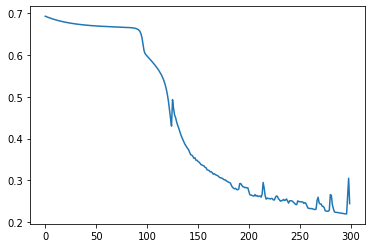

In [44]:
# Plot do erro durante o treinamento
plt.plot(custo)

In [45]:
# Previsões com os dados de treino
y_pred_treino = predict(X_treino, parametros)

In [46]:
# Visualiza as previsões
y_pred_treino

array([[8.68204443e-01, 8.68174014e-01, 8.68233759e-01, 8.68208387e-01,
        8.68191434e-01, 8.68173407e-01, 5.76745672e-02, 8.68169500e-01,
        8.38422619e-01, 8.26671435e-08, 1.39057146e-11, 8.68202938e-01,
        8.68207495e-01, 8.68062347e-01, 2.40166570e-06, 2.62630537e-01,
        4.58839617e-02, 8.68193091e-01, 1.18773605e-04, 8.68185242e-01,
        8.68169543e-01, 8.68179445e-01, 8.68209043e-01, 8.67109252e-01,
        8.42419524e-01, 1.77806870e-01, 8.52221736e-01, 6.28957319e-01,
        2.86598344e-01, 3.18222024e-02, 8.06927227e-08, 8.68184580e-01,
        7.77567148e-01, 8.68185073e-01, 3.96718595e-01, 8.68205529e-01,
        8.68221963e-01, 8.68235577e-01, 8.68193308e-01, 8.47695248e-01,
        8.68163953e-01, 8.68210136e-01, 8.68187973e-01, 4.03756610e-02,
        8.68204376e-01, 8.68208407e-01, 8.68253770e-01, 8.68206003e-01,
        8.68195988e-01, 8.68211808e-01, 8.69515284e-26, 8.68184227e-01,
        8.68193784e-01, 3.78068442e-01, 7.78124532e-04, 7.467431

In [47]:
# Ajustamos o shape em treino
y_pred_treino = y_pred_treino.reshape(-1)
y_treino = y_treino.reshape(-1)

In [48]:
y_pred_treino > 0.5

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True, False,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True, False,

In [49]:
# Convertemos as previsões para o valor binário de classe 
# (0 ou 1, usando como threshold o valor de 0.5 da probabilidade)
y_pred_treino = 1 * (y_pred_treino > 0.5)

In [50]:
y_pred_treino

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,

In [51]:
# Calculamos a acurácia comparando valor real com valor previsto
acc_treino = sum(1 * (y_pred_treino == y_treino)) / len(y_pred_treino) * 100

In [52]:
print("Acurácia nos dados de treino: " + str(acc_treino))

Acurácia nos dados de treino: 91.51138716356108


In [53]:
print(classification_report(y_treino, y_pred_treino, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.99      0.78      0.88       185
     Benigno       0.88      1.00      0.94       298

    accuracy                           0.92       483
   macro avg       0.94      0.89      0.91       483
weighted avg       0.92      0.92      0.91       483



In [54]:
# Previsões com o modelo usando dados de teste
y_pred_teste = predict(X_teste, parametros)

In [55]:
# Visualiza os dados
y_pred_teste

array([[8.68190396e-01, 7.69171321e-04, 2.90212514e-21, 2.83845114e-02,
        5.35330424e-06, 2.26550401e-06, 8.68172009e-01, 8.68178319e-01,
        7.01463856e-01, 4.26856750e-01, 8.68230439e-01, 8.68206015e-01,
        8.68171691e-01, 4.99615290e-08, 8.68218595e-01, 8.68206017e-01,
        8.19399044e-01, 1.36954903e-01, 3.27097807e-10, 8.68206393e-01,
        8.66358256e-01, 8.68176568e-01, 5.83357142e-02, 8.44291928e-01,
        8.68196705e-01, 8.68213514e-01, 8.68186530e-01, 8.68198700e-01,
        2.10396991e-03, 5.31135632e-04, 8.68184813e-01, 8.68194680e-01,
        8.65988398e-01, 8.68180529e-01, 8.68212065e-01, 8.68189324e-01,
        8.68177259e-01, 8.68180631e-01, 8.68204394e-01, 8.68203582e-01,
        8.68206762e-01, 8.68196656e-01, 8.68204089e-01, 8.68195209e-01,
        5.81913464e-01, 2.90768150e-01, 8.68182554e-01, 8.68218886e-01,
        8.68198298e-01, 8.37568833e-01, 8.68201174e-01, 3.40108057e-01,
        8.68180580e-01, 8.68183369e-01, 7.10751759e-01, 8.682060

In [56]:
# Ajustamos os shapes
y_pred_teste = y_pred_teste.reshape(-1)
y_teste = y_teste.reshape(-1)

In [57]:
# Convertemos as previsões para o valor binário de classe
y_pred_teste = 1 * (y_pred_teste > 0.5)

In [58]:
# Visualizamos as previsões
y_pred_teste

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [59]:
# Calculamos a acurácia
acuracia = sum(1 * (y_pred_teste == y_teste)) / len(y_pred_teste) * 100

In [60]:
print("Acurácia nos dados de teste: " + str(acuracia))

Acurácia nos dados de teste: 89.53488372093024


In [61]:
print(classification_report(y_teste, y_pred_teste, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.95      0.70      0.81        27
     Benigno       0.88      0.98      0.93        59

    accuracy                           0.90        86
   macro avg       0.91      0.84      0.87        86
weighted avg       0.90      0.90      0.89        86

